In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x1 = torch.linspace(0, 0.95, 50) + 0.05 * torch.rand(50)
train_x2 = torch.linspace(0, 0.95, 25) + 0.05 * torch.rand(25)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x2)

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
model1 = ExactGPModel(train_x1, train_y1, likelihood1)

likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
model2 = ExactGPModel(train_x2, train_y2, likelihood2)

In [4]:
model = gpytorch.models.IndependentModelList(model1, model2)
likelihood = gpytorch.likelihoods.LikelihoodList(model1.likelihood, model2.likelihood)

In [5]:
from gpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

In [7]:
# this is for running the notebook in our testing framework
#import os
#smoke_test = ('CI' in os.environ)
#training_iterations = 2 if smoke_test else 50

training_iterations = 50
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.065
Iter 2/50 - Loss: 1.032
Iter 3/50 - Loss: 0.995
Iter 4/50 - Loss: 0.954
Iter 5/50 - Loss: 0.908
Iter 6/50 - Loss: 0.860
Iter 7/50 - Loss: 0.810
Iter 8/50 - Loss: 0.762
Iter 9/50 - Loss: 0.716
Iter 10/50 - Loss: 0.675
Iter 11/50 - Loss: 0.638
Iter 12/50 - Loss: 0.606
Iter 13/50 - Loss: 0.576
Iter 14/50 - Loss: 0.548
Iter 15/50 - Loss: 0.519
Iter 16/50 - Loss: 0.491
Iter 17/50 - Loss: 0.462
Iter 18/50 - Loss: 0.432
Iter 19/50 - Loss: 0.402
Iter 20/50 - Loss: 0.372
Iter 21/50 - Loss: 0.343
Iter 22/50 - Loss: 0.315
Iter 23/50 - Loss: 0.288
Iter 24/50 - Loss: 0.264
Iter 25/50 - Loss: 0.243
Iter 26/50 - Loss: 0.225
Iter 27/50 - Loss: 0.211
Iter 28/50 - Loss: 0.199
Iter 29/50 - Loss: 0.190
Iter 30/50 - Loss: 0.184
Iter 31/50 - Loss: 0.179
Iter 32/50 - Loss: 0.177
Iter 33/50 - Loss: 0.175
Iter 34/50 - Loss: 0.175
Iter 35/50 - Loss: 0.176
Iter 36/50 - Loss: 0.177
Iter 37/50 - Loss: 0.179
Iter 38/50 - Loss: 0.180
Iter 39/50 - Loss: 0.180
Iter 40/50 - Loss: 0.180
Iter 41/5

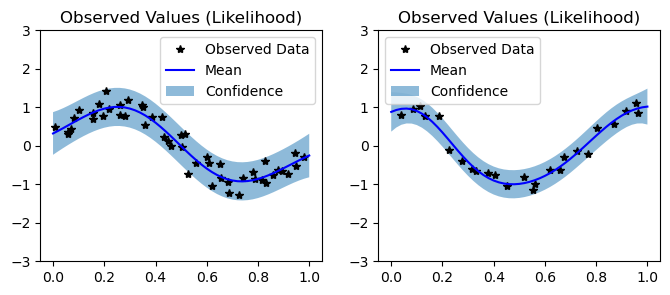

In [8]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))

for submodel, prediction, ax in zip(model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region()

    tr_x = submodel.train_inputs[0].detach().numpy()
    tr_y = submodel.train_targets.detach().numpy()

    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')

None